In [1]:
import os
os.environ["PATH"] = "/usr/local/cuda-11.8/bin:{}".format(os.environ["PATH"])
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-11.8/lib64"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append("/data1/yang_liu/python_workspace/GSPL")

import torch
import numpy as np
import random
from torch import nn

from internal.utils.ssim import ssim
from matplotlib import pyplot as plt
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.dataparsers.colmap_dataparser import ColmapParams, ColmapDataParser
from internal.dataparsers.colmap_block_dataparser import ColmapBlockParams, ColmapBlockDataParser
from internal.dataparsers.estimated_depth_colmap_block_dataparser import EstimatedDepthColmapBlockParams, EstimatedDepthColmapDataParser
from internal.renderers.vanilla_renderer import VanillaRenderer
from internal.renderers.vanilla_trim_renderer import VanillaTrimRenderer
from internal.renderers.sep_depth_trim_2dgs_renderer import SepDepthTrim2DGSRenderer
from internal.utils.sh_utils import eval_gaussian_model_sh
from internal.utils.graphics_utils import fetch_ply
from internal.utils.general_utils import inverse_sigmoid
from internal.models.gaussian_model import GaussianModel
from internal.utils.blocking import contract_to_unisphere

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# load dataset
dataparser_outputs = EstimatedDepthColmapDataParser(
    os.path.expanduser("../data/matrix_city/aerial/test/block_all_test"),
    os.path.abspath(""),
    global_rank=0,
    params=EstimatedDepthColmapBlockParams(
        # split_mode="experiment",
        # eval_image_select_mode="ratio",
        # eval_ratio=0.1,
        down_sample_factor=1.2,
    ),
).get_outputs()
print("Train camera count: {}".format(len(dataparser_outputs.train_set.cameras)))

appearance group by camera id
loading colmap 3D points
down sample enabled
[colmap dataparser] train set images: 741, val set images: 93, loaded mask: 0
found 834 depth maps
Train camera count: 741


In [3]:
# load from scratch
# file_dir = "../data/matrix_city/street/train/block_A/sparse/0/points3D.ply"
# model = GaussianModel(sh_degree=3)
# model.create_from_pcd(fetch_ply(file_dir), device='cuda')
# # model._scaling = nn.Parameter(torch.log(torch.exp(model._scaling) / 100.0))
# model._opacity = nn.Parameter(inverse_sigmoid(torch.ones((model.get_xyz.shape[0], 1), dtype=torch.float, device="cuda")))
# renderer = VanillaRenderer()
# renderer.setup(stage="val")
# renderer = renderer.to("cuda")


# load from checkpoint
load_from = "../outputs/citygs2d_mc_aerial_lnorm4_wo_vast_sep_depth_trim_sh2"
model, renderer = GaussianModelLoader.search_and_load(load_from, sh_degree=2, device="cuda")
# from internal.renderers.vanilla_2dgs_renderer import Vanilla2DGSRenderer
# renderer = Vanilla2DGSRenderer()
if isinstance(renderer, VanillaTrimRenderer):
    model._scaling = torch.cat((torch.ones_like(model._scaling[:, :1]) * 1e-8, model._scaling[:, [-2, -1]]), dim=1)
    flatten_gs = True
else:
    flatten_gs = False
print("Gaussian count: {}".format(model.get_xyz.shape[0]))

error occurred when parsing iteration from ../outputs/citygs2d_mc_aerial_lnorm4_wo_vast_sep_depth_trim_sh2/checkpoints/epoch=6-step=30000_rebuttal.ckpt: invalid literal for int() with base 10: '30000_rebuttal'
Gaussian count: 11959111


In [4]:
xyz = contract_to_unisphere(model.get_xyz, torch.tensor([-3.5, -4, -10, 4.5, 2, 10], device=model.get_xyz.device), ord=torch.inf)

In [14]:
# p1: 0.513, p2: 0.560, p3: 0.474, p4: 0.388, p5: 0.314

block_id = 26
block_dim = [6, 6, 1]

block_id_z = block_id // (block_dim[0] * block_dim[1])
block_id_y = (block_id % (block_dim[0] * block_dim[1])) // block_dim[0]
block_id_x = (block_id % (block_dim[0] * block_dim[1])) % block_dim[0]

min_x, max_x = float(block_id_x) / block_dim[0], float(block_id_x + 1) / block_dim[0]
min_y, max_y = float(block_id_y) / block_dim[1], float(block_id_y + 1) / block_dim[1]
min_z, max_z = float(block_id_z) / block_dim[2], float(block_id_z + 1) / block_dim[2]
delta_x = 1.0 * (max_x - min_x)
delta_y = 1.0 * (max_y - min_y)
delta_z = 1.0 * (max_z - min_z)

block_mask = (xyz[..., 0] >= min_x - delta_x) & (xyz[..., 0] < max_x + delta_x) & \
            (xyz[..., 1] >= min_y - delta_y) & (xyz[..., 1] < max_y + delta_y) & \
            (xyz[..., 2] >= min_z - delta_z) & (xyz[..., 2] < max_z + delta_z)

print("Block mask count: {}".format(block_mask.sum()))

Block mask count: 5125871


## 1. Just Rendering

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00014301049..1.2433844].


Image 0214.png


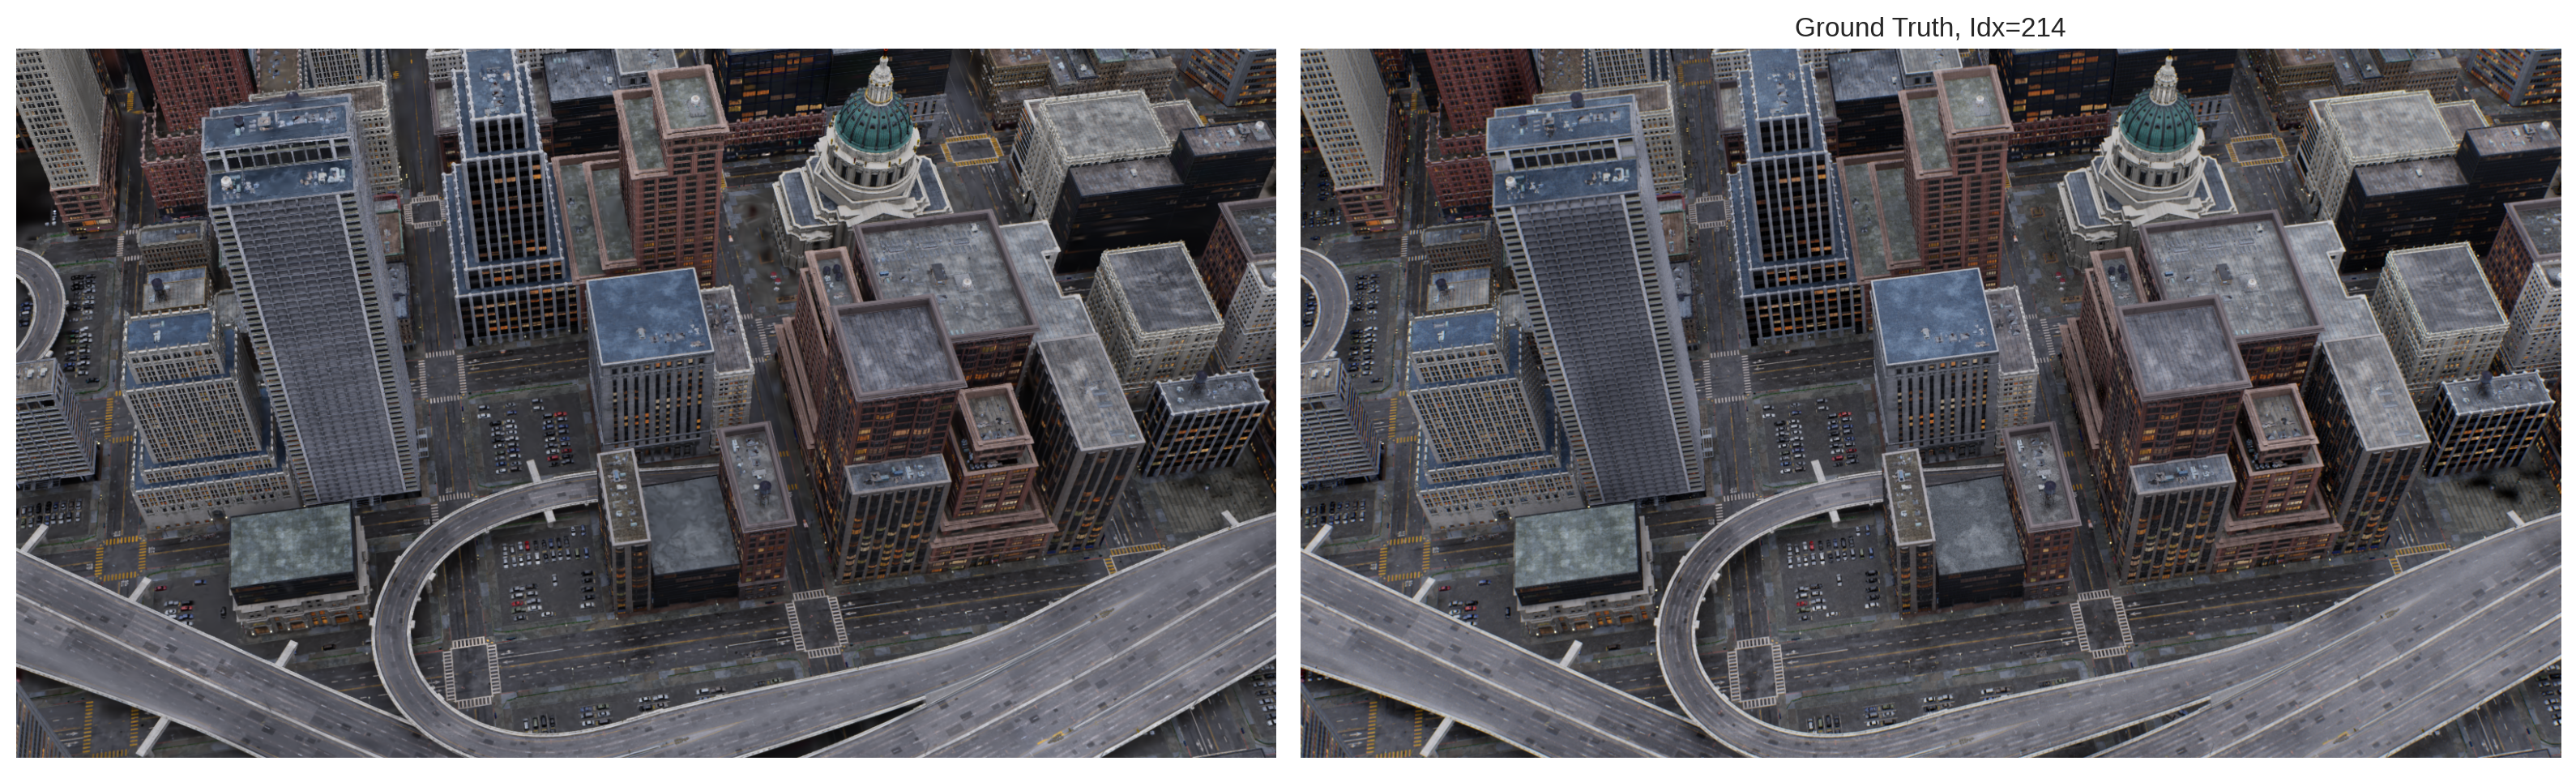

In [5]:
# Test image render
with torch.no_grad():
    # pick a camera
    # idx = random.randint(0, len(dataparser_outputs.train_set.cameras) - 1)
    idx = 214  # 30, 60, 90, 395
    # model._scaling = org_scaling.clone()
    camera = dataparser_outputs.train_set.cameras[idx].to_device("cuda")

    # gemerate masks
    # homo_xyz = torch.cat((model.get_xyz, torch.ones_like(model.get_xyz[:, :1])), dim=-1)
    # xyz_proj = homo_xyz @ camera.world_to_camera
    # xyz_proj = homo_xyz @ camera.full_projection
    # xyz_proj = xyz_proj[:, :3] / xyz_proj[:, [3]]
    # mask = xyz_proj[:, 2] < 0.999
    # opacity_threshold = 1.0
    # mask = model._opacity_origin < opacity_threshold  # opacity mask
    # mask = (model.get_scaling[:, :2].min(dim=1)[0] / model.get_scaling[:, :2].max(dim=1)[0]) < 0.1  # distance mask
    # scaling_threshold = 10.0
    # mask = model.get_scaling[:, :2].max(dim=1)[0] < scaling_threshold
    # model.select(block_mask)
    # model._scaling = model._scaling[:, [1,0,2]]

    image_path = dataparser_outputs.train_set.image_paths[idx]
    gt = torch.tensor(plt.imread(image_path), dtype=torch.float, device="cuda").permute(2, 0, 1)
    if gt.max() > 1:
        gt /= 255.0
    gt_depth = dataparser_outputs.train_set.extra_data_processor(dataparser_outputs.train_set.extra_data[idx])
    # gt_depth = (gt_depth - gt_depth.min()) / (gt_depth.max() - gt_depth.min())
    results = renderer(camera, model, bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"))
    # results["render"][results["render"]==0] = 0.3


print(f"Image {dataparser_outputs.train_set.image_names[idx]}")
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(16, 8))
plt.tight_layout()
plt.subplot(1, 2, 1)
plt.imshow(results["render"].permute(1, 2, 0).cpu().numpy())

# pred_depth = 1. / (results["surf_depth"].clamp_min(0.).squeeze() + 1e-8)
# clamp_val = pred_depth.mean() + 2 * pred_depth.std()
# pred_depth = pred_depth.clamp(0, clamp_val) / clamp_val
# # pred_depth = (pred_depth - pred_depth.min()) / (pred_depth.max() - pred_depth.min())
# plt.imshow(pred_depth.cpu().numpy())
# plt.title(f"Extracted Depth, Idx={idx}")

# normal = (results["surf_normal"].permute(1, 2, 0))
# plt.imshow(normal.cpu().numpy());
# plt.title(f"Rend Normal, Idx={idx}")

plt.axis('off')
plt.subplot(1, 2, 2)

plt.imshow(gt.permute(1, 2, 0).cpu().numpy())

# clamp_val = clamp_val.cpu()
# gt_depth = gt_depth.clamp(0, clamp_val) / clamp_val
# plt.imshow(gt_depth.cpu().numpy())

# normal = (results["rend_normal"].permute(1, 2, 0))
# plt.imshow(normal.cpu().numpy());

plt.title(f"Ground Truth, Idx={idx}")
plt.axis('off')
plt.tight_layout()

/tmp/ipykernel_17025/3256771591.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xyz[::100, 0].cpu().numpy(), xyz[::100, 1].cpu().numpy(), s=1, cmap="viridis")
/tmp/ipykernel_17025/3256771591.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xyz[mask][::100, 0].cpu().numpy(), xyz[mask][::100, 1].cpu().numpy(), s=1, cmap="red")


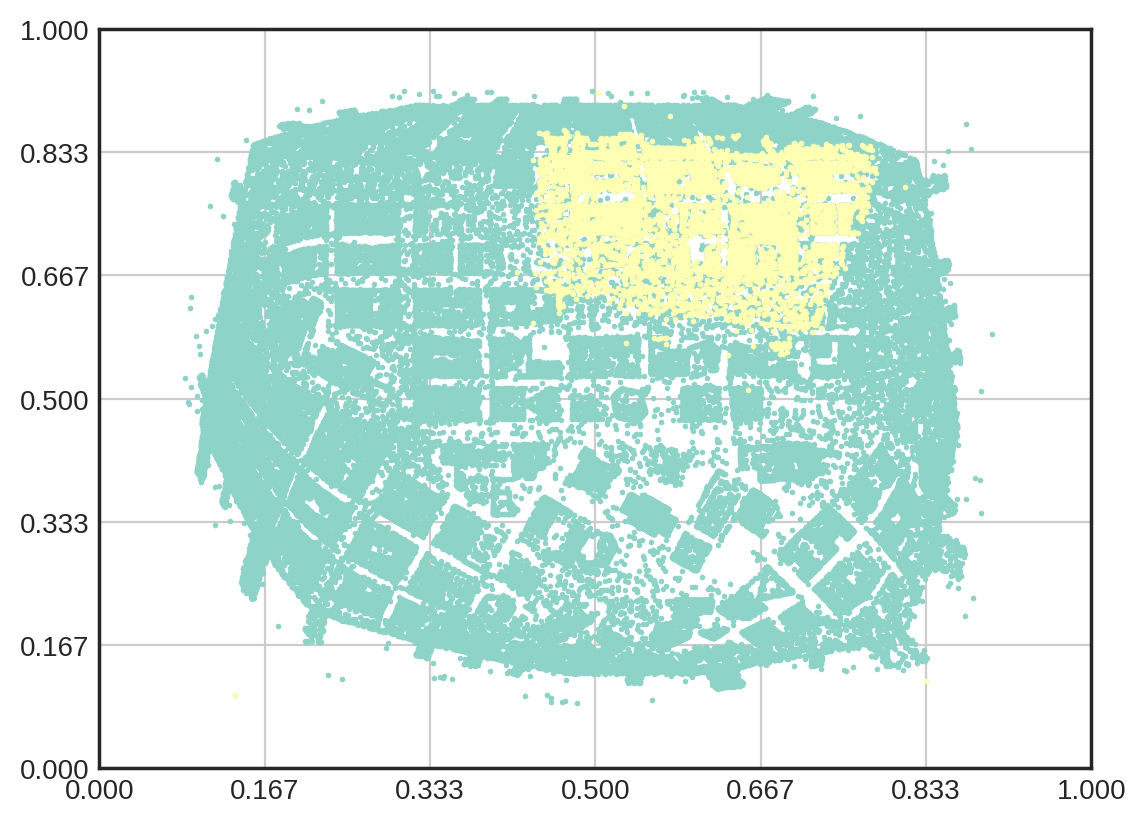

In [6]:
plt.style.use('seaborn-v0_8-white')
plt.figure()

mask = results["visibility_filter"].squeeze().cpu().numpy()
plt.scatter(xyz[::100, 0].cpu().numpy(), xyz[::100, 1].cpu().numpy(), s=1, cmap="viridis")
plt.scatter(xyz[mask][::100, 0].cpu().numpy(), xyz[mask][::100, 1].cpu().numpy(), s=1, cmap="red")
plt.xticks(np.linspace(0, 1, 7, endpoint=True))
plt.yticks(np.linspace(0, 1, 7, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)

In [32]:
import open3d as o3d
from internal.utils.mesh_utils import to_cam_open3d

volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=1,
    sdf_trunc=8,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8
)

rgb = results['render']
depth = results['surf_depth']

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(np.asarray(rgb.permute(1,2,0).cpu().numpy() * 255, order="C", dtype=np.uint8)),
    o3d.geometry.Image(np.asarray(depth.permute(1,2,0).cpu().numpy(), order="C")),
    depth_trunc = 500, convert_rgb_to_intensity=False,
    depth_scale = 1.0
)

cam_o3d = to_cam_open3d(dataparser_outputs.train_set.cameras)[idx]

volume.integrate(rgbd, intrinsic=cam_o3d.intrinsic, extrinsic=cam_o3d.extrinsic)

mesh = volume.extract_triangle_mesh()
o3d.io.write_triangle_mesh('./single_frame.ply', mesh)

# debug mode
# pcd = volume.extract_voxel_point_cloud()
# o3d.io.write_point_cloud('./single_frame_vox.ply', pcd)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


True

In [ ]:
plt.hist(pred_depth.cpu().numpy().flatten(), range=(0, 1.0), bins=100, alpha=0.5, label="pred");
plt.hist(gt_depth.cpu().numpy().flatten(), range=(0, 1.0), bins=100, alpha=0.5, label="gt");
print(f"Mean of pred: {pred_depth.mean()}, Mean of gt: {gt_depth.mean()}")
print(f"STD of pred: {pred_depth.std()}, STD of gt: {gt_depth.std()}")

## 2. Rendering and Analysis

In [ ]:
ckpt = torch.load(load_from)["gaussian_model_extra_state_dict"]
max_radii2D, xyz_gradient_accum, denom = ckpt["max_radii2D"], ckpt["xyz_gradient_accum"], ckpt["denom"]
org_xyz = model._xyz.clone()

In [ ]:
# grad = (xyz_gradient_accum / denom).squeeze()
# grad = xyz_gradient_accum.squeeze()
# grad_mean = xyz_gradient_accum.mean()
# grad_std = xyz_gradient_accum.std()
# grad_mask = grad < grad_mean + grad_std * 3
# grad_mask = grad < 0.0002
# grad_mask = torch.zeros_like(grad, dtype=torch.bool)
grad_mask = (model.get_scaling[:, :2].min(dim=1)[0] / model.get_scaling[:, :2].max(dim=1)[0]) > 0.01
# model._scaling = model._scaling[:, [1,0,2]]
# model._xyz[~grad_mask] = org_xyz[~grad_mask].clone()
# model._xyz[~grad_mask] = model._xyz[~grad_mask] * 1.02
# model._scaling = model._scaling[:, [1,0,2]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image DJI_20240223163905_0040_Zenmuse-L1-mission.JPG


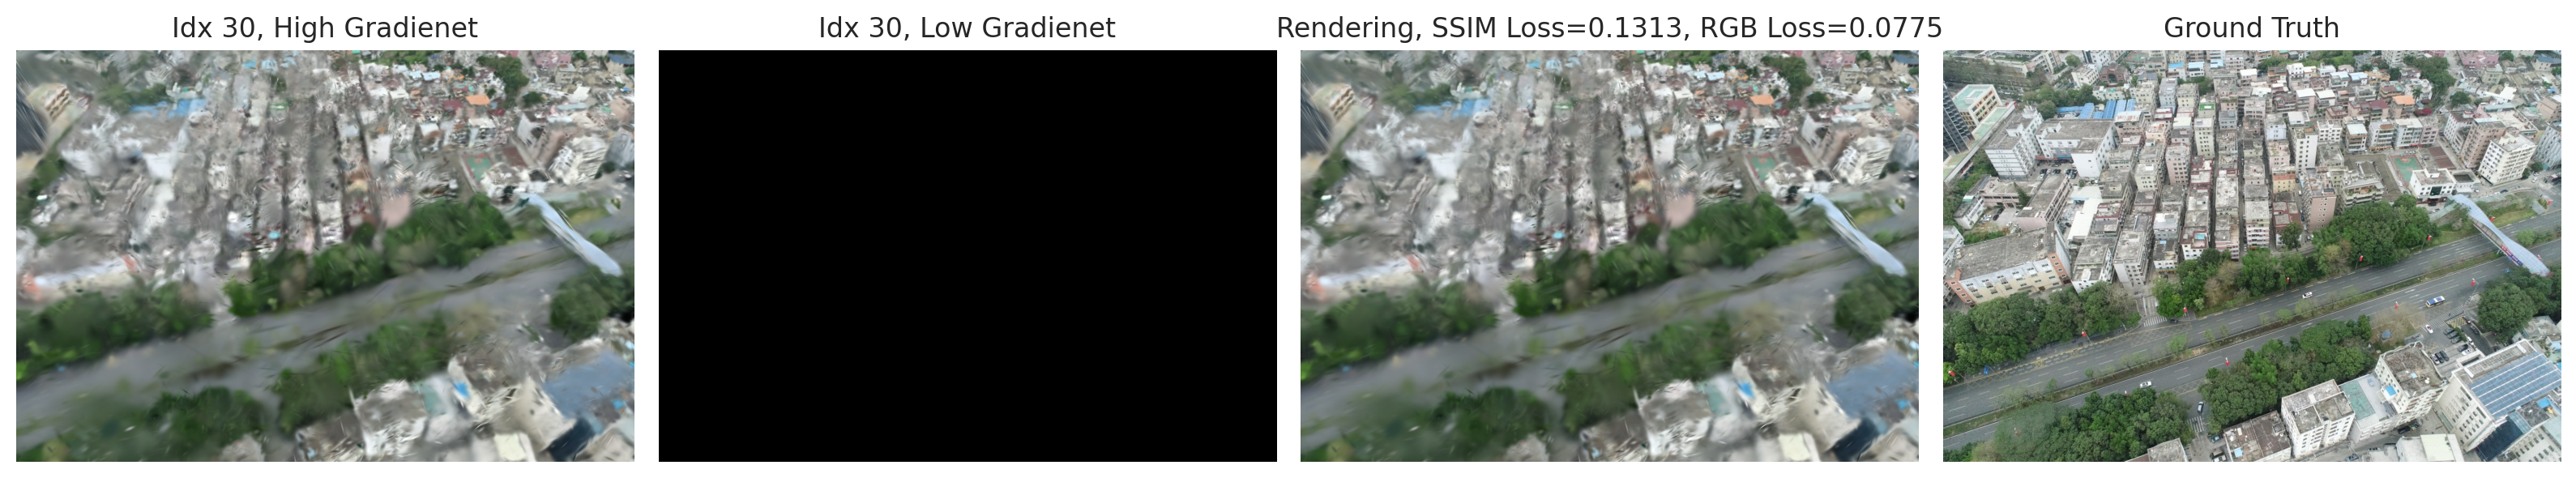

In [ ]:
# Test image render
with torch.no_grad():
    # pick a camera
    # idx = random.randint(0, len(dataparser_outputs.train_set.cameras) - 1)
    idx = 30  # 30, 60, 90, 395
    camera = dataparser_outputs.train_set.cameras[idx].to_device("cuda")
    image_path = dataparser_outputs.train_set.image_paths[idx]
    gt = torch.tensor(plt.imread(image_path), dtype=torch.float, device="cuda").permute(2, 0, 1) / 255.0

    model.select(grad_mask)
    filtered_results = renderer(camera, model, bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"))
    
    model.select(~grad_mask)
    remained_results = renderer(camera, model, bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"))
    
    model.select(torch.zeros_like(grad, dtype=torch.bool))
    org_results = renderer(camera, model, bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"))
    ssim_loss = 0.2 * (1 - ssim(org_results["render"], gt).item())
    l1_loss = 0.8 * torch.abs(org_results["render"] - gt).mean().item()

print(f"Image {dataparser_outputs.train_set.image_names[idx]}")
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(16, 8))
plt.tight_layout()
plt.subplot(1, 4, 1)
plt.imshow(filtered_results["render"].permute(1, 2, 0).cpu().numpy())
plt.title(f"Idx {idx}, High Gradienet")
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(remained_results["render"].permute(1, 2, 0).cpu().numpy())
plt.title(f"Idx {idx}, Low Gradienet")
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(org_results["render"].permute(1, 2, 0).cpu().numpy())
plt.title("Rendering, SSIM Loss={:.4f}, RGB Loss={:.4f}".format(ssim_loss, l1_loss))
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(gt.permute(1, 2, 0).cpu().numpy())
plt.title("Ground Truth")
plt.axis('off')
plt.tight_layout()

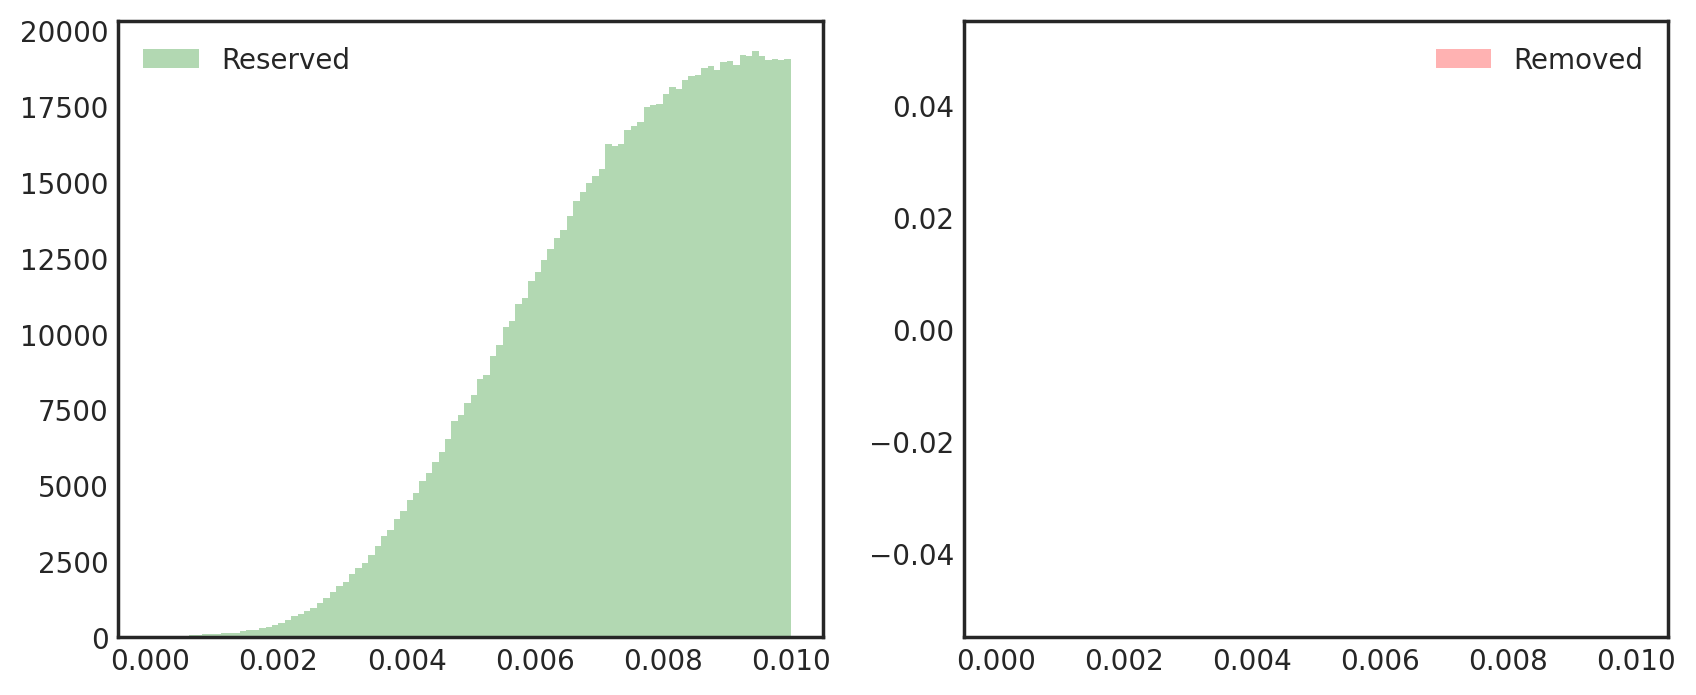

In [ ]:
radius_reserved = model.get_scaling[~grad_mask.squeeze(), :2].norm(dim=1)
radius_removed = model.get_scaling[grad_mask.squeeze(), :2].norm(dim=1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(radius_reserved.cpu().numpy(), bins=100, range=(0, 0.01), alpha=0.3, color='g', label="Reserved");
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(radius_removed.cpu().numpy(), bins=100, range=(0, 0.01), alpha=0.3, color='r', label="Removed");
plt.legend()
plt.show()

# scaling_reserved = max_radii2D[~grad_mask.squeeze() & (results["radii"]>0)]
# scaling_removed = max_radii2D[grad_mask.squeeze() & (results["radii"]>0)]
# print(f"Average scaling of reserved gaussians: {scaling_reserved.mean(dim=0)}")
# print(f"Average scaling of removed gaussians: {scaling_removed.mean(dim=0)}")